In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scvelo as scv
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
scv.set_figure_params('scvelo')  # for beautified visualization
%load_ext autoreload
%autoreload 2

Using device cpu


# 05h Single Cell Dataset Benchmarker with PHATE
> Run FRED on a specified single cell dataset, using UMAP embeddings

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05h Single Cell Dataset Benchmarker with PHATE base"
dataset_name = "pancreas"
sigma = 'automatic'
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 1
contrastive_loss_weight = 0
diffdist_weight = 100
num_neighbors = 5

# Set Up

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
import os
from pathlib import Path

# choose correct dataset
Xpath = f"../../data/{dataset_name}/processed/X.txt"
if os.path.exists(Xpath):
    X = np.loadtxt(Xpath)
    flow = np.loadtxt(f"../../data/{dataset_name}/processed/flow.txt")
    labels = np.loadtxt(f"../../data/{dataset_name}/processed/labels.txt")
    latent_time = np.loadtxt(f"../../data/{dataset_name}/processed/latent_time.txt")
else:
    if dataset_name == "bone marrow":
        adata = scv.datasets.bonemarrow()
    elif dataset_name == "dentategyrus":
        adata = scv.datasets.dentategyrus()
    elif dataset_name == "pancreas":
        adata = scv.datasets.pancreas()
    elif dataset_name == "dentategyrus_lamanno":
        adata = scv.datasets.dentategyrus_lamanno()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    # dynamical recovery
    scv.tl.recover_dynamics(adata, n_jobs=7)
    scv.tl.latent_time(adata)
    latent_time = adata.obs['latent_time'].to_numpy()
    # save the processed data to np txt files for ready loading in the future
    Path(f"data/{dataset_name}/processed").mkdir(parents = True,exist_ok=True)
    np.savetxt(f"data/{dataset_name}/processed/X.txt",X)
    np.savetxt(f"data/{dataset_name}/processed/flow.txt",flow)
    np.savetxt(f"data/{dataset_name}/processed/labels.txt",labels)
    np.savetxt(f"data/{dataset_name}/processed/latent_time.txt",latent_time)


Set sigma =  8.403331
Computing PHATE with phate_decay=40 and self.n_neighbors=5
X is tensor([[-13.6794,  14.4443,  -2.0508,  ...,   1.5196,   1.7939,   0.5915],
        [ -2.0034,  -4.4326,   6.7553,  ...,   0.9907,   0.4587,   0.2311],
        [-12.2434,  16.4074,  -1.5515,  ...,  -1.8877,   0.4154,  -0.5711],
        ...,
        [  0.3926,  -2.5394,   9.8178,  ...,  -2.0105,  -0.3223,   0.2489],
        [-10.9474,  11.4025,  -5.8244,  ...,   0.4090,   0.7200,   0.2548],
        [-12.9658,  15.5302,  -4.2545,  ...,  -0.2912,  -0.5371,  -1.3741]])
Calculating PHATE...
  Running PHATE on 3696 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.50 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.53 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.27 seconds.
    Calculating KMeans.

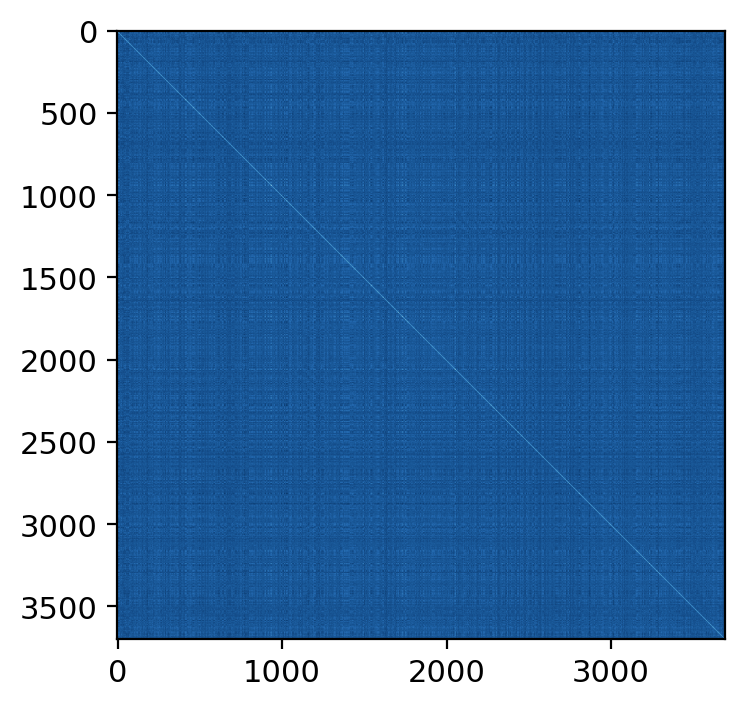

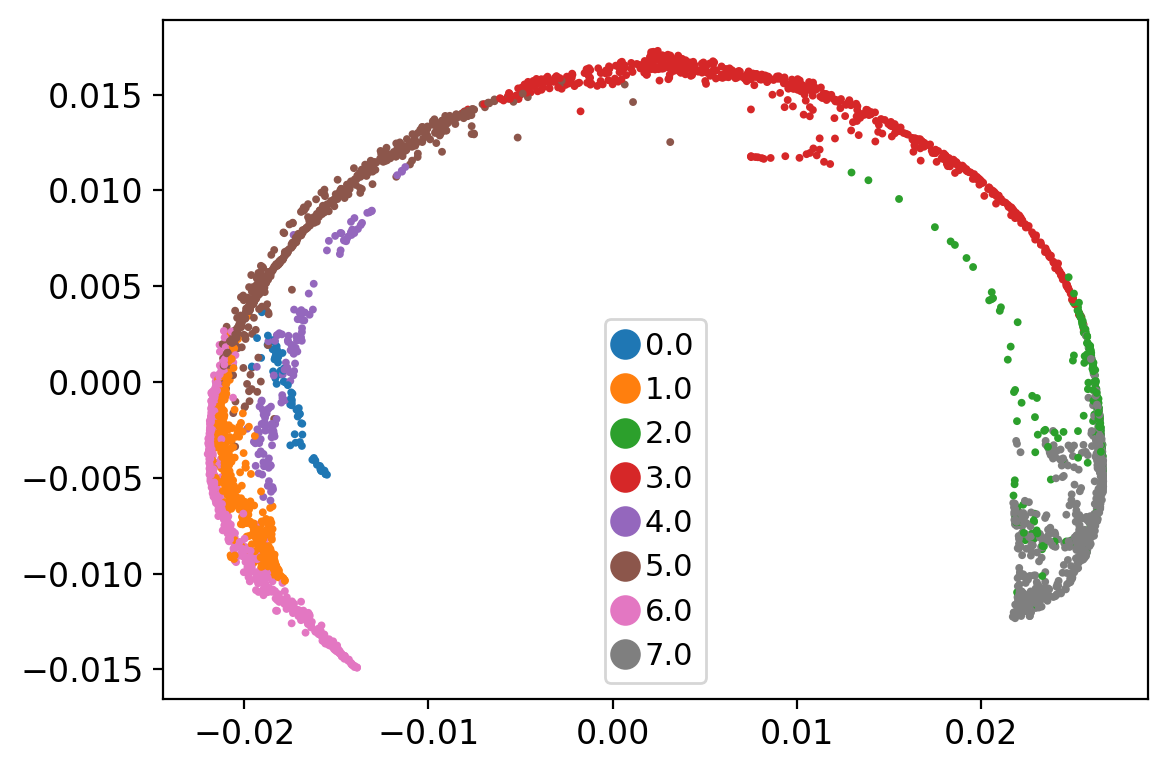

In [ ]:
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength, prior_embedding="PHATE")
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','').replace("/","-")
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[X.shape[1], 20, 10, 5, 2],
            device=device,
            sigma=5,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "distance regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
            "contrastive loss":contrastive_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=50)

  2%|▏         | 1/50 [00:29<24:12, 29.64s/it]

{'distance regularization': tensor(0.0004, dtype=torch.float64, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(0.0031, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.1205, grad_fn=<MulBackward0>)}


 22%|██▏       | 11/50 [03:20<11:15, 17.33s/it]

{'distance regularization': tensor(0.0003, dtype=torch.float64, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(0.0046, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.1724, grad_fn=<MulBackward0>)}


 42%|████▏     | 21/50 [06:03<08:06, 16.77s/it]

{'distance regularization': tensor(0.0002, dtype=torch.float64, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(0.0088, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.1188, grad_fn=<MulBackward0>)}


 62%|██████▏   | 31/50 [08:53<05:29, 17.36s/it]

{'distance regularization': tensor(0.0002, dtype=torch.float64, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(0.0075, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.1060, grad_fn=<MulBackward0>)}


 82%|████████▏ | 41/50 [11:41<02:31, 16.88s/it]

{'distance regularization': tensor(0.0002, dtype=torch.float64, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(0.0068, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.1560, grad_fn=<MulBackward0>)}


100%|██████████| 50/50 [14:12<00:00, 17.04s/it]


In [ ]:
torch.max(ds.precomputed_distances)

tensor(1., dtype=torch.float64)

# Results

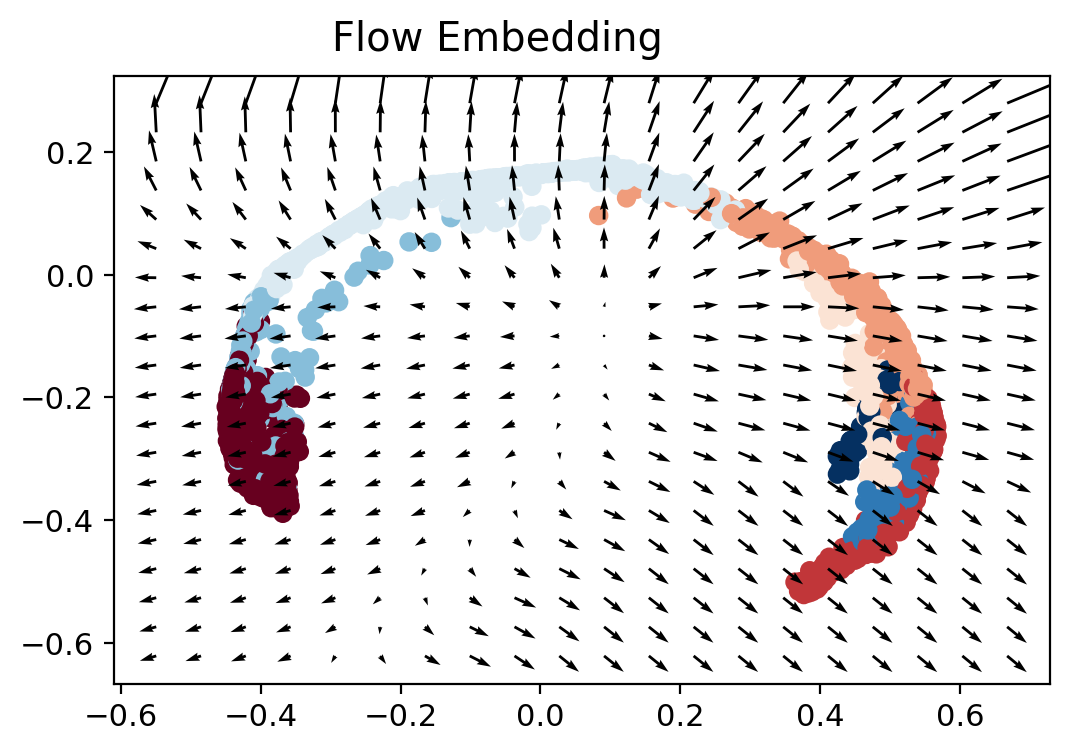

In [ ]:
FREDtrainer.visualize_embedding(use_streamlines=False)

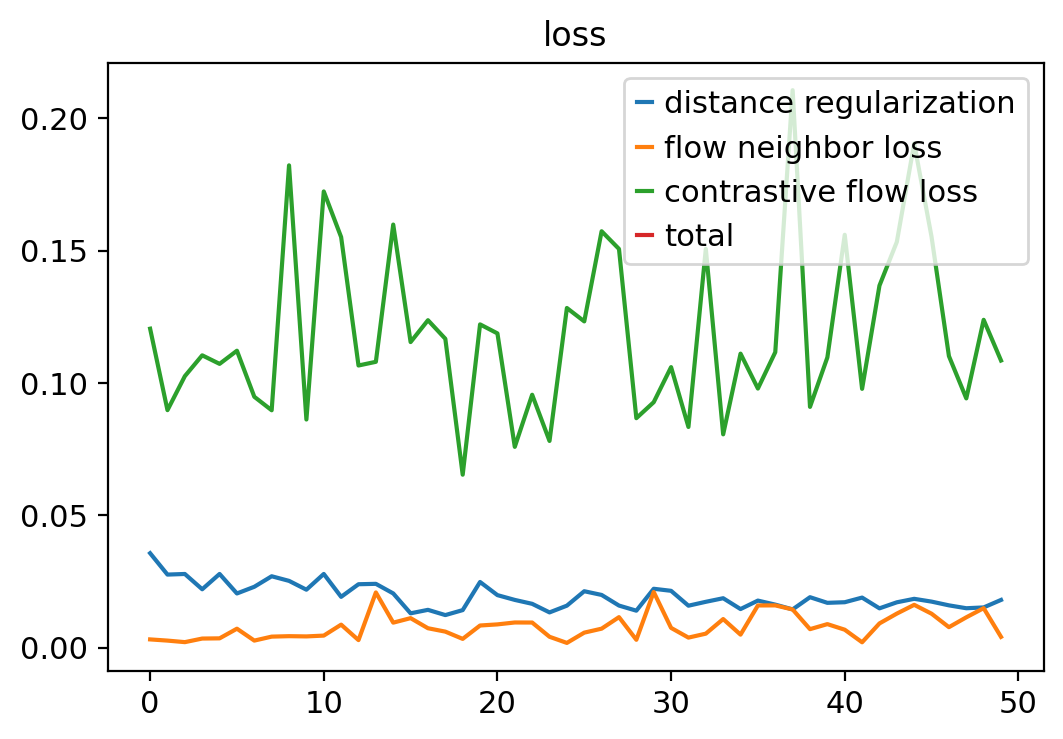

In [ ]:
FREDtrainer.visualize_loss()

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhhANYAocAAP///////f//+///+P7///z///v///3//f3/+fn///j///f///…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
spread_name = notebook.replace('/','-') + "_dataset_" + dataset_name
unid

't9PJfrytFcRdq1XIqpyO'

In [ ]:
from FRED.metrics import comprehensive_flow_metrics
silhouette_score, silhouete_score_with_flow, knn_score, neighbor_score, monotone_score = comprehensive_flow_metrics(
    X = X,
    flows = flow,
    labels = labels,
    embedded_points = embedded_points,
    embedded_velocities = embedded_velocities,
    time_labels = latent_time,
    spreadsheet_name=spread_name,
    unid = unid,
    flow_strength = flow_strength
)
print(f"{silhouette_score=} {silhouete_score_with_flow=} {knn_score=} {neighbor_score=} {monotone_score=}")

Set sigma =  8.403331002941993


  0%|          | 0/100 [00:00<?, ?it/s]

Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241
Set sigma =  0.006404241


In [ ]:
import csv
with open(f"results/{spread_name}.csv", 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(
            [unid,
            sigma,
            flow_strength,
            flow_neighbor_loss_weight,
            contrastive_flow_loss_weight,
            num_neighbors,
            smoothness_weight,
            diffdist_weight,
            silhouette_score,
            silhouete_score_with_flow,
            knn_score,
            neighbor_score, 
            monotone_score,
            ])

FileNotFoundError: [Errno 2] No such file or directory: 'results/05h Single Cell Dataset Benchmarker with PHATE base_dataset_pancreas.csv'

# Save embeddings to txt files

In [ ]:
filename = f"{spread_name} - {dataset_name} - {unid}"
np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach().cpu().numpy())
np.savetxt(f'embeddings/{filename} - V.txt',FREDtrainer.embedded_velocities.detach().cpu().numpy())